In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ma
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
import pyproj
import geopandas as gpd
pyproj.set_use_global_context(True)

In [2]:
sns.set_style('white')
sns.set(font_scale=1.5)

In [3]:
data = et.data.get_data('cold-springs-fire')
data_2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

Extracted output to /home/codespace/earth-analytics/data/cs-test-landsat/.


In [4]:
def open_clean_band(band_path, crop_layer=None):
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()

    return cleaned_band

In [5]:
def process_bands(paths, crop_layer=None, stack=False):
    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

In [6]:
lnst_dirpth_pre = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "*band[2-4]*.tif")

lnst_pths_pre = sorted(glob(lnst_dirpth_pre))

lndst_pre = process_bands(lnst_pths_pre, stack=True)
lndst_pre

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 523kB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  8481
    STATISTICS_MEAN:     664.90340361031
    STATISTICS_MINIMUM:  -767
    STATISTICS_STDDEV:   1197.873301452
    scale_factor:        1.0
    add_offset:          0.0

In [8]:
lnst_pre_cl_pth = os.path.join("cold-springs-fire",
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604",
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

lndst_qa = rxr.open_rasterio(lnst_pre_cl_pth).squeeze()
hgh_cld_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cld = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cld_shdw = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_msked_vals = cld_shdw + cld + hgh_cld_confidence

lndst_pre_cl_masked = lndst_pre.where(~lndst_qa.isin(all_msked_vals))

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


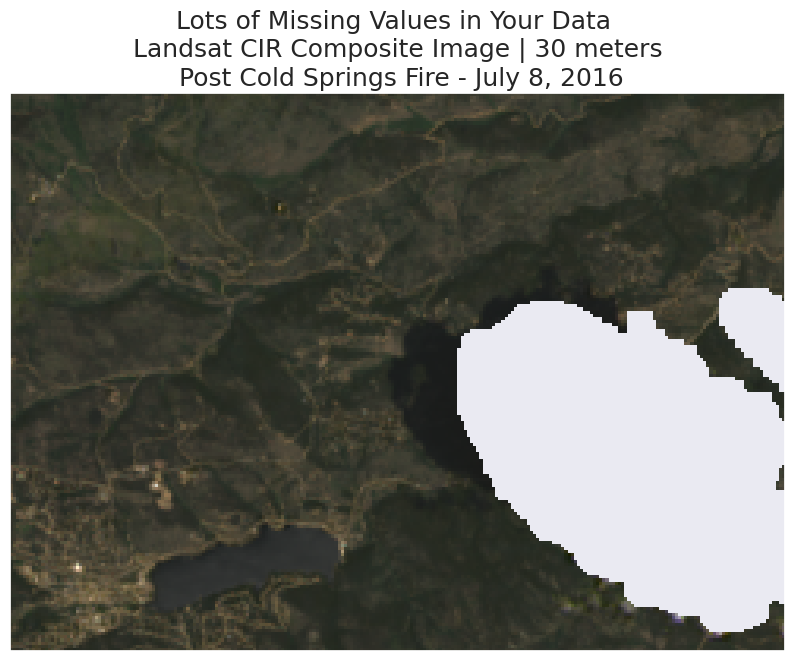

In [11]:
ep.plot_rgb(lndst_pre_cl_masked,
            rgb=[2, 1, 0],
            title="Lots of Missing Values in Your Data \n Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire - July 8, 2016")

plt.show()

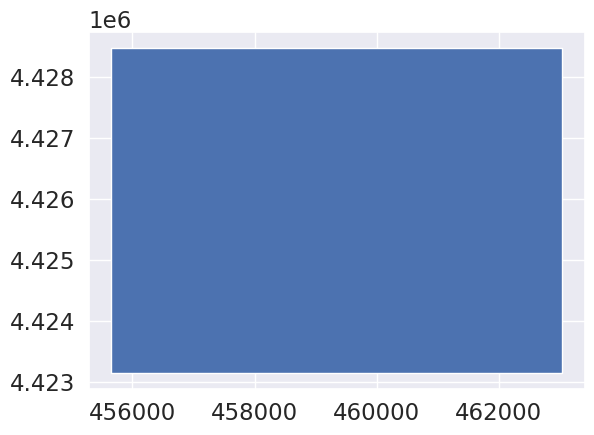

In [13]:
lndst_pre_cld_ext_bds = lndst_pre.rio.bounds()

df = {'id': [1],
      'geometry': box(*lndst_pre.rio.bounds())}

clip_gdf = gpd.GeoDataFrame(df, crs=lndst_pre.rio.crs)
clip_gdf.plot()
plt.show()

In [14]:
cld_free_pth = os.path.join("cs-test-landsat", 
                                "*band[2-4]*.tif")
lnst_pths_pre_cld_free = sorted(glob(cld_free_pth))
lndst_pre_cld_free = process_bands(lnst_pths_pre_cld_free,
                                   stack=True,
                                   crop_layer=clip_gdf)
lndst_pre_cld_free

I'm stacking your data now.


<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 1MB
array([[[590., 629., 636., ..., 218., 234., 283.],
        [546., 580., 598., ..., 248., 270., 314.],
        [484., 503., 506., ..., 284., 325., 348.],
        ...,
        [434., 431., 438., ..., 290., 291., 303.],
        [441., 490., 478., ..., 292., 312., 313.],
        [340., 278., 297., ..., 299., 334., 337.]],

       [[781., 808., 828., ..., 461., 485., 535.],
        [748., 795., 807., ..., 491., 519., 574.],
        [727., 754., 743., ..., 535., 590., 627.],
        ...,
        [722., 724., 722., ..., 550., 554., 569.],
        [706., 777., 756., ..., 546., 577., 591.],
        [578., 484., 500., ..., 548., 590., 607.]],

       [[770., 839., 845., ..., 331., 363., 412.],
        [730., 793., 812., ..., 379., 421., 479.],
        [657., 692., 691., ..., 441., 522., 573.],
        ...,
        [697., 789., 797., ..., 497., 486., 505.],
        [837., 788., 802., ..., 476., 505., 508.],
        [542., 477., 465., ..., 510., 536., 536.]]])
Coordinates:
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         band 2 surface reflectance
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      band 2 surface reflectance

In [19]:
lndst_no_clds_bds = lndst_pre_cld_free.rio.bounds()
lndst_pre_cld_ext_bds = lndst_pre.rio.bounds()

print("The cloud free data bounds are:", lndst_no_clds_bds)
print("The original cloud covered data bounds are:", lndst_pre_cl_masked.rio.bounds())
print("Are the bounds the same?", lndst_no_clds_bds == lndst_pre_cld_ext_bds)

The cloud free data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
The original cloud covered data bounds are: (455655.0, 4423155.0, 463035.0, 4428465.0)
Are the bounds the same? True


In [20]:
cld_free_scn_bds = box(*lndst_no_clds_bds)
cldy_scn_bds = box(*lndst_pre_cld_ext_bds)

cld_free_scn_bds.intersects(cldy_scn_bds)

True

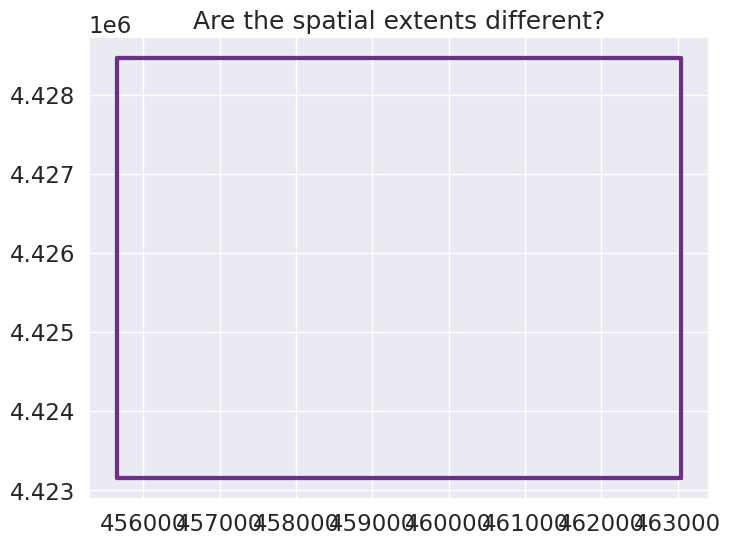

In [23]:
x, y = cld_free_scn_bds.exterior.xy
x1, y1 = cldy_scn_bds.exterior.xy

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x, y,
        color='teal',
        alpha=0.7,
        linewidth=3,
        solid_capstyle='round',
        zorder=2)
ax.plot(x1, y1,
        color='purple',
        alpha=0.7,
        linewidth=3,
        solid_capstyle='round',
        zorder=2)

ax.set_title('Are the spatial extents different?')

plt.show()

In [24]:
lndst_pre.rio.crs == lndst_pre_cld_free.rio.crs

True

In [25]:
lndst_pre.shape == lndst_pre_cld_free.shape

True

In [28]:
mask = lndst_pre_cl_masked.isnull()

lndst_pre_clds_filled = xr.where(mask, lndst_pre_cld_free, lndst_pre_cl_masked)
lndst_pre_clds_filled

<xarray.DataArray (band: 3, y: 177, x: 246)> Size: 1MB
array([[[ 443.,  456.,  446., ...,  213.,  251.,  293.],
        [ 408.,  420.,  436., ...,  226.,  272.,  332.],
        [ 356.,  375.,  373., ...,  261.,  329.,  383.],
        ...,
        [ 407.,  427.,  428., ...,  306.,  273.,  216.],
        [ 545.,  552.,  580., ...,  307.,  315.,  252.],
        [ 350.,  221.,  233., ...,  320.,  348.,  315.]],

       [[ 635.,  641.,  629., ...,  360.,  397.,  454.],
        [ 601.,  617.,  620., ...,  380.,  418.,  509.],
        [ 587.,  600.,  573., ...,  431.,  513.,  603.],
        ...,
        [ 679.,  742.,  729., ...,  493.,  482.,  459.],
        [ 816.,  827.,  824., ...,  461.,  502.,  485.],
        [ 526.,  388.,  364., ...,  463.,  501.,  512.]],

       [[ 625.,  671.,  651., ...,  265.,  307.,  340.],
        [ 568.,  620.,  627., ...,  309.,  354.,  431.],
        [ 513.,  510.,  515., ...,  362.,  464.,  565.],
        ...,
        [ 725.,  834.,  864., ...,  485.,  467.,  457.],
        [1031.,  864.,  844., ...,  438.,  457.,  429.],
        [ 525.,  432.,  411., ...,  465.,  472.,  451.]]])
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 2kB 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 1kB 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
    spatial_ref  int64 8B 0